# Phase 1 - Ingestion and Cleaning


In [ ]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn as sns

In [ ]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [ ]:
# Define the directories that contain the files downloaded
dir_cs = "./case_study_data/2003_download/" # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = dir_cs + "clean_data.pickle" # path to save cleaned data

In [ ]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ["id", "loan_amnt","funded_amnt", "term", "int_rate", "grade", "emp_length", "home_ownership","annual_inc", 
                "verification_status", "issue_d", "loan_status", "purpose", "dti","delinq_2yrs", 
                "earliest_cr_line", "open_acc", "pub_rec", "fico_range_high","fico_range_low", 
                "revol_bal", "revol_util", "total_pymnt", "recoveries","last_pymnt_d"] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ["loan_amnt","funded_amnt","annual_inc", "dti","delinq_2yrs","open_acc","pub_rec","fico_range_high",
              "fico_range_low","revol_bal","total_pymnt","recoveries"]
cat_cols = ["term","grade","verification_status","emp_length","home_ownership","verification_status","loan_status","purpose"] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [ ]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [ ]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(dir_cs) if isfile(join(dir_cs, f))]
onlyfiles

['LoanStats3a_securev1.csv.zip',
 'LoanStats3b_securev1.csv.zip',
 'LoanStats3c_securev1.csv.zip',
 'LoanStats3d_securev1.csv.zip',
 'LoanStats_securev1_2016Q1.csv.zip',
 'LoanStats_securev1_2016Q2.csv.zip',
 'LoanStats_securev1_2016Q3.csv.zip',
 'LoanStats_securev1_2016Q4.csv.zip',
 'LoanStats_securev1_2017Q1.csv.zip',
 'LoanStats_securev1_2017Q2.csv.zip',
 'LoanStats_securev1_2017Q3.csv.zip',
 'LoanStats_securev1_2017Q4.csv.zip',
 'LoanStats_securev1_2018Q1.csv.zip',
 'LoanStats_securev1_2018Q2.csv.zip',
 'LoanStats_securev1_2018Q3.csv.zip',
 'LoanStats_securev1_2018Q4.csv.zip',
 'LoanStats_securev1_2019Q1.csv.zip',
 'LoanStats_securev1_2019Q2.csv.zip',
 'LoanStats_securev1_2019Q3.csv.zip',
 'LoanStats_securev1_2019Q4.csv.zip']

In [ ]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory+"/"
    
    all_files = [f for f in listdir(directory) if isfile(join(directory, f))] # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory+i,skiprows=1,dtype='str') # read each with dtype='str' and skip_rows =1
        df=output[i]
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = np.array([0 if is_integer(id) else 1 for id in df["id"]]) # mask rows that have non-integer IDs. Use is_integer method
        
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = df[~invalid_rows.astype(bool)] # remove invalid rows
    
    return output # return dictionary of dataframe

In [ ]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory ./case_study_data/2003_download/ has 20 files:
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q3.csv.zip
Fo

### Combine the files

In [ ]:

data_cs = pd.concat([value for value in files_cs.values()]) # combine "files_cs" into a pandas dataframe
data_cs.head()
data_cs.reset_index(drop=True)             # resent index with drop = True


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000,5000,4975,36 months,10.65%,162.87,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500,2500,2500,60 months,15.27%,59.83,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,NaN,2400,2400,2400,36 months,15.96%,84.33,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,NaN,10000,10000,10000,36 months,13.49%,339.31,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,NaN,3000,3000,3000,60 months,12.69%,67.79,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777771,158872331,NaN,3000,3000,3000,36 months,17.74%,108.07,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2777772,158833440,NaN,10000,10000,10000,36 months,6.46%,306.31,A,A1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2777773,158748525,NaN,19000,19000,19000,36 months,6.46%,581.99,A,A1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2777774,158298751,NaN,10000,10000,10000,60 months,28.80%,316.21,D,D5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


## Prepare Final Dataset

In [ ]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]


In [ ]:
print("Starting with " + str(len(final_data)) + " rows")


Starting with 2777776 rows


### Typecast the columns

In [ ]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = final_data[i].astype(float) # typecast float columns

C:\Users\nahse\AppData\Local\Temp/ipykernel_13588/1286980223.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].astype(float) # typecast float columns


In [ ]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = [clean_perc(x) for x in final_data[i]] # apply clean_perc to percentage columns

C:\Users\nahse\AppData\Local\Temp/ipykernel_13588/2931331333.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = [clean_perc(x) for x in final_data[i]] # apply clean_perc to percentage columns


In [ ]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = [clean_date(d) for d in final_data[i]] # typecast date cloumns to datatime using clean_date

C:\Users\nahse\AppData\Local\Temp/ipykernel_13588/2668861694.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = [clean_date(d) for d in final_data[i]] # typecast date cloumns to datatime using clean_date


In [ ]:
for i in cat_cols:
    final_data[i]=final_data[i].where(pd.notnull(final_data[i]),None) # for categorical features if the value is null/empty set it to None

C:\Users\nahse\AppData\Local\Temp/ipykernel_13588/2343038025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i]=final_data[i].where(pd.notnull(final_data[i]),None) # for categorical features if the value is null/empty set it to None


## Calculate returns for each loan

In [ ]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [ ]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

final_data = final_data[final_data["loan_length"]!=0] # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

C:\Users\nahse\AppData\Local\Temp/ipykernel_13588/1300551504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')


Removed 12361 rows


### M1-Pessimistic Method

In [ ]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

final_data['ret_PESS'] = ((final_data["total_pymnt"]-final_data["funded_amnt"])/final_data["funded_amnt"])*(12/final_data["term_num"])

### M2-Optimistic Method

In [ ]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return
final_data['m2_months'] = np.round(((final_data["last_pymnt_d"]-final_data["issue_d"])/np.timedelta64(1, 'M')),0)

final_data['ret_OPT'] = ((final_data["total_pymnt"]-final_data["funded_amnt"])/final_data["funded_amnt"])*(12/final_data["m2_months"])

final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = ((final_data.loc[final_data.ret_OPT < 0,"total_pymnt"]-final_data.loc[final_data.ret_OPT < 0,"funded_amnt"])
                                                    /final_data.loc[final_data.ret_OPT < 0,"funded_amnt"]
                                                   )*(12/final_data.loc[final_data.ret_OPT < 0,"term_num"])

### Method 3

In [ ]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data["loan_length"]
    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * ((1-(1+i)**(final_data["loan_length"]))/(1-(1+i))) #Compute the quantity given in [] in eq.2.3 of handout
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * np.power(1+i,remaining_months) - final_data["funded_amnt"]

    # Find the percentage return
    ret_val = (12/T) * final_return*(1/final_data["funded_amnt"])
    return ret_val

In [ ]:
final_data['ret_INTa'] = ret_method_3(60,0.023) # call ret_method_3 with T=60, i=0.023
final_data['ret_INTb'] = ret_method_3(60,0.04) # call ret_method_3 with T=60, i=0.04

In [ ]:
final_data[["ret_INTa","ret_INTb"]]

,ret_INTa,ret_INTb
0,0.413340,1.075884
1,0.058081,0.401688
2,0.502458,1.318829
3,0.439784,1.130894
4,0.367104,0.861487
...,...,...
128132,0.573186,1.844198
128133,-0.109684,0.033061
128134,-0.110082,0.032035
128135,-0.107674,0.038248


### Visualize the variables

In [ ]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        #highest_vals = final_data[i].sort_values()[:3] # get 3 highest values
        highest_vals = final_data[i].sort_values(ascending=False)[:3].values # get 3 highest values
        print(highest_vals)
        
        smallest_val = min(final_data[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [ ]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print(i) # print field name
        print(final_data[i].unique()) # print number of distinct values
        print(final_data[i].value_counts()) # for each distinct value print the number of occurances
        print("")
        print("")

In [ ]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[40000. 40000. 40000.]


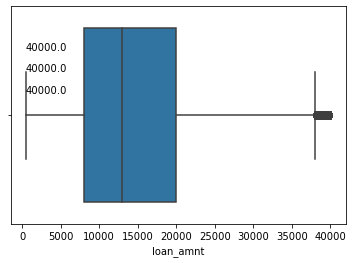

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[40000. 40000. 40000.]


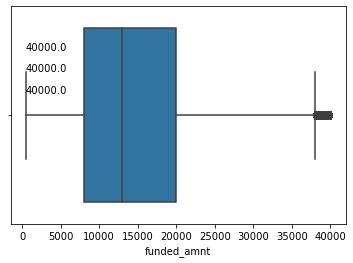

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[1.10000e+08 6.10000e+07 1.09992e+07]


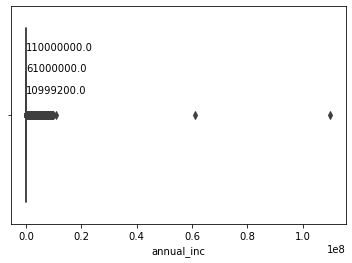

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[999. 999. 999.]


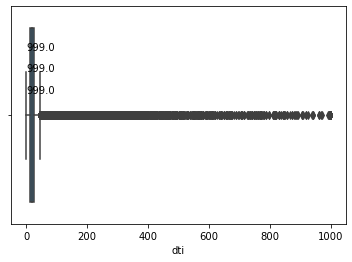

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[58. 42. 39.]


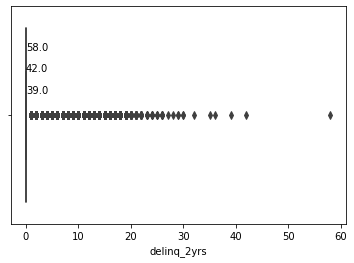

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[104. 101.  97.]


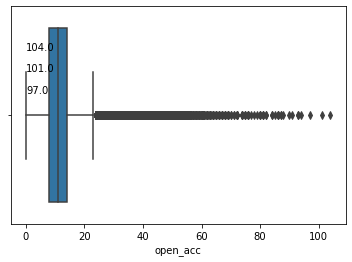

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[86. 63. 61.]


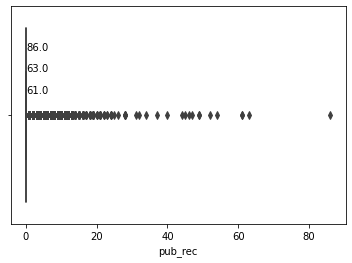

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[850. 850. 850.]


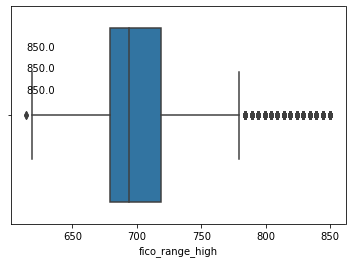

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[845. 845. 845.]


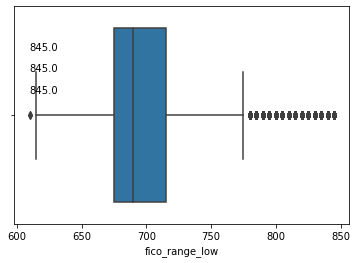

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[2904836. 2568995. 2560703.]


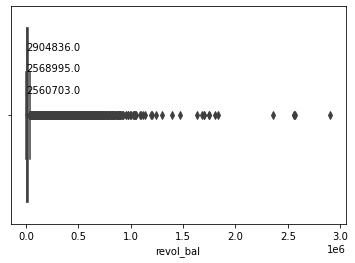

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[62493.74666644 62154.73255658 62106.5196627 ]


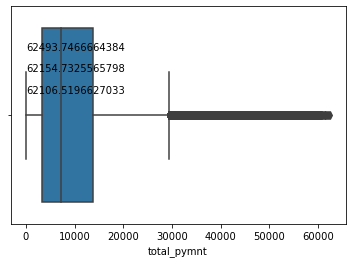

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[41803.25 39444.37 38650.  ]


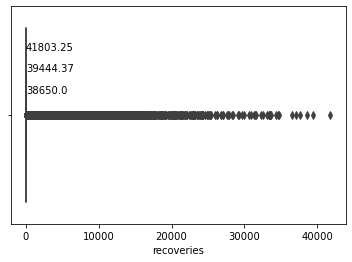

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[30.99 30.99 30.99]


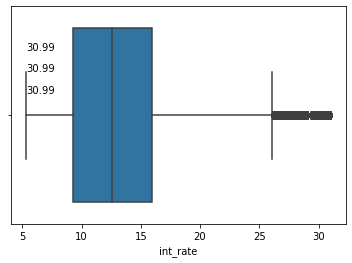

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[892.3 366.6 193. ]


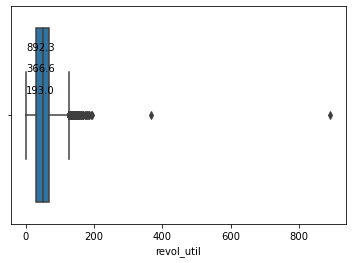

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[0.3901     0.1929856  0.18033239]


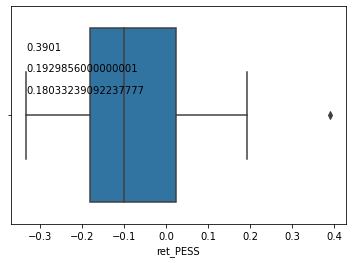

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[2.49792    1.6119168  1.60840417]


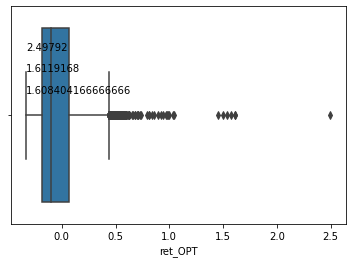

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[0.75977852 0.74864805 0.73503033]


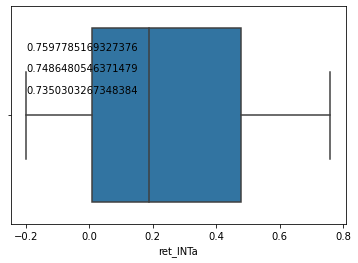

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[2.2680874  2.24236581 2.09310672]


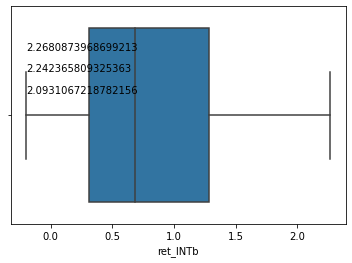

term
[' 36 months' ' 60 months']
 36 months    1949756
 60 months     815659
Name: term, dtype: int64


grade
['B' 'C' 'A' 'E' 'F' 'D' 'G']
B    811304
C    768632
A    596277
D    397211
E    138329
F     41596
G     12066
Name: grade, dtype: int64


verification_status
['Verified' 'Source Verified' 'Not Verified']
Source Verified    1066701
Not Verified        997623
Verified            701091
Name: verification_status, dtype: int64


emp_length
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' None]
10+ years    898370
< 1 year     253650
2 years      247379
3 years      219762
1 year       183001
5 years      171829
4 years      166566
6 years      123700
7 years      110120
8 years      107507
9 years       91449
Name: emp_length, dtype: int64


home_ownership
['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
MORTGAGE    1359007
RENT        1090600
OWN          312178
ANY            3393
OTHER           182
NONE         

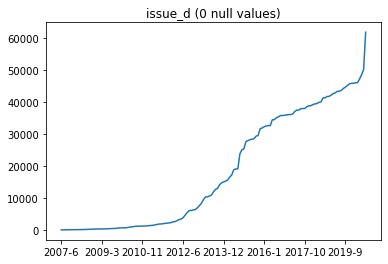

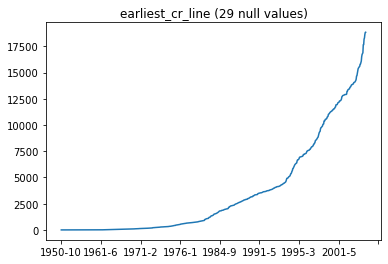

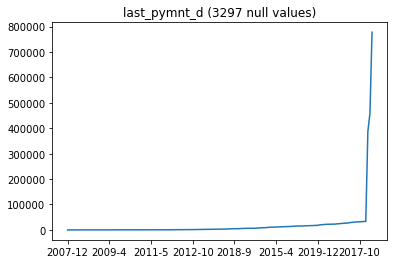

In [ ]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

### Handle outliers

In [ ]:
# There are quite a few outliers. 
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious
n_rows = len(final_data)

#df[np.abs(df.Data-df.Data.mean()) <= (3*df.Data.std())]


#Using the IQR method to check for outliers and remove them as seen by Boxplots
# Columns ["annual_inc","dti","delinq_2yrs","pub_rec","revol_bal","recoveries","open_acc"] seem to have a large number
# of outliers based on visualization
# But removing "delinq_2yrs","pub_rec","recoveries" using IQR lead to a high data loss since most of the values were 0.

outliers_col = ["annual_inc","dti","revol_bal","open_acc"]

for col in outliers_col:
    quart1 = final_data[col].quantile(0.25)
    quart3 = final_data[col].quantile(0.75)
    IQR = quart3 - quart1
    lower = quart1 - 1.5 * IQR
    upper = quart3 + 1.5 * IQR

    final_data = final_data[final_data[col] < upper]
    final_data = final_data[final_data[col]>lower]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 380629 rows


In [ ]:
# Remove all loans that are still current
n_rows = len(final_data)

#final_data = final_data[[final_data["loan_status"]!="Fully Paid" and final_data["loan_status"]!="Charged-Off" and final_data["loan_status"]!="Default"]]
final_data=final_data[final_data["loan_status"].isin(["Fully Paid","Charged Off","Default"])]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1374368 rows


In [ ]:
# Only include loans isssued since 2010
n_rows = len(final_data)
final_data = final_data[final_data["issue_d"].astype(str)>="2010-01-01"]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 5935 rows


### Drop null values

In [ ]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

final_data.dropna(inplace=True,subset=required_cols) # drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 3267 rows


### Visualize clean data

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[40000. 40000. 40000.]


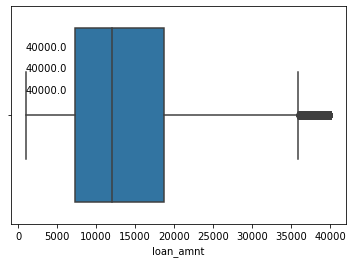

[40000. 40000. 40000.]


C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


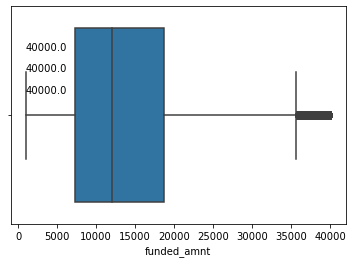

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[166900. 166850. 166850.]


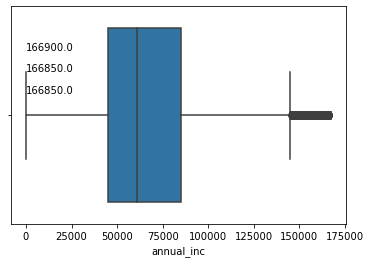

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[44.18 44.18 44.18]


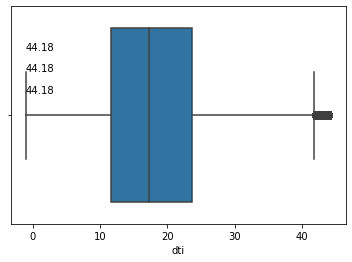

[39. 30. 29.]


C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


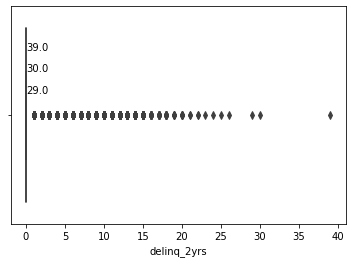

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[24. 24. 24.]


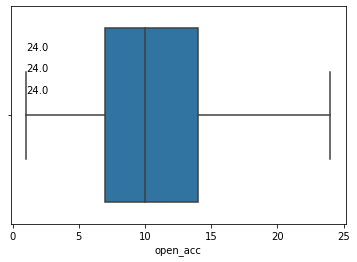

[86. 63. 54.]


C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


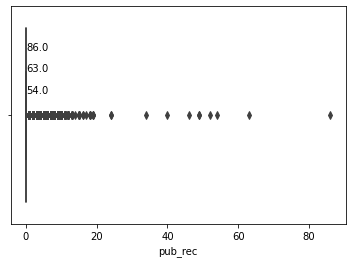

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[850. 850. 850.]


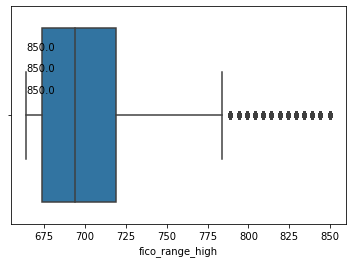

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[845. 845. 845.]


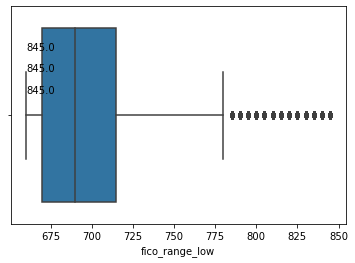

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[39770. 39770. 39770.]


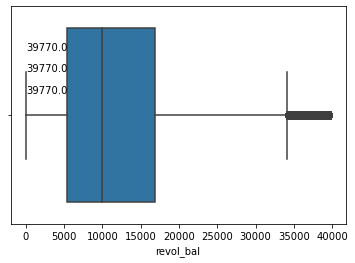

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[62493.74666644 61557.69403594 61501.87966896]


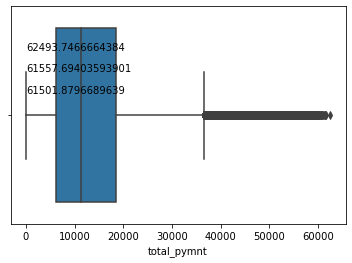

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[39444.37 36578.54 34655.15]


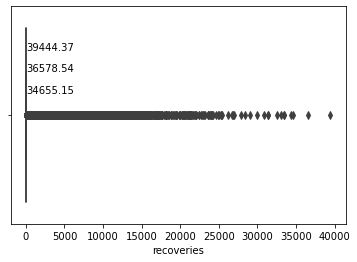

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[30.99 30.99 30.99]


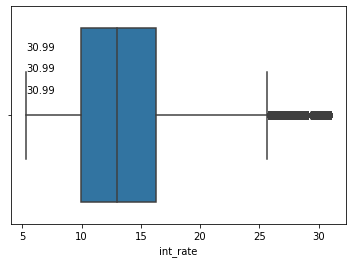

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[892.3 366.6 182.8]


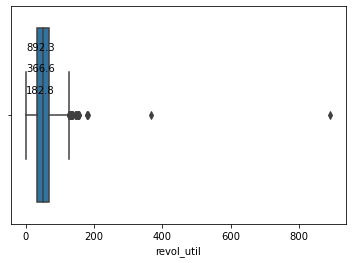

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[0.18033239 0.17572453 0.16382663]


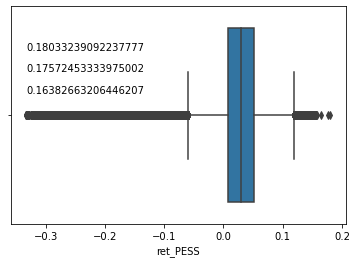

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[1.6119168  1.60840417 1.577916  ]


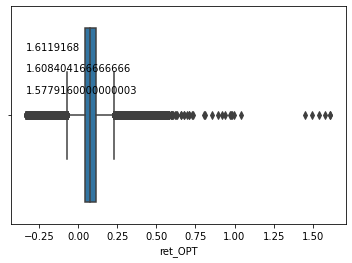

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[0.74864805 0.73503033 0.72947965]


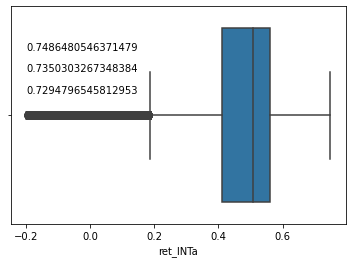

C:\Users\nahse\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[2.2680874  2.09310672 2.09028955]


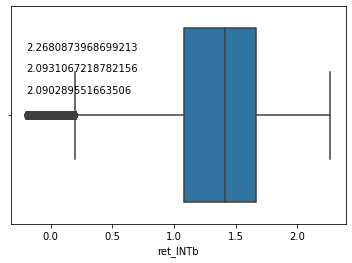

term
[' 36 months' ' 60 months']
 36 months    762529
 60 months    238687
Name: term, dtype: int64


grade
['B' 'C' 'A' 'E' 'F' 'D' 'G']
B    288388
C    278718
A    177007
D    157755
E     69839
F     23484
G      6025
Name: grade, dtype: int64


verification_status
['Verified' 'Source Verified' 'Not Verified']
Source Verified    371612
Not Verified       334775
Verified           294829
Name: verification_status, dtype: int64


emp_length
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' None]
10+ years    317313
2 years       91440
3 years       81219
< 1 year      80958
1 year        66792
5 years       64254
4 years       61267
6 years       48661
7 years       45774
8 years       44897
9 years       36605
Name: emp_length, dtype: int64


home_ownership
['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
MORTGAGE    478135
RENT        416358
OWN         106079
ANY            558
OTHER           46
NONE            40
Name

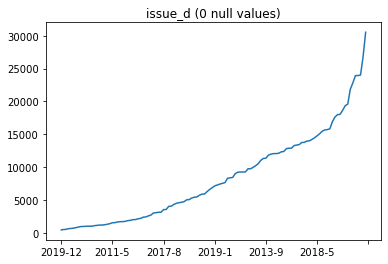

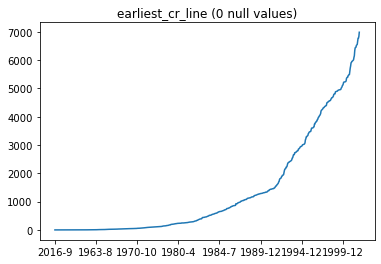

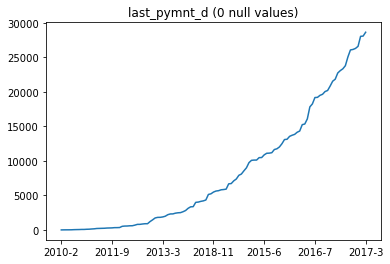

In [ ]:
# Visualize the data again after cleaning

# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

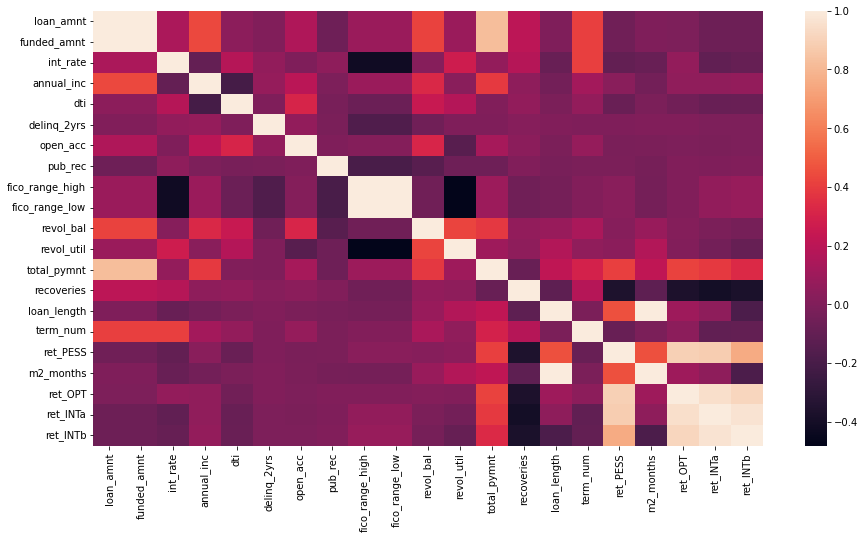

In [ ]:
# Visualize the feature correlations
    # You can compute the correlation among features and display a heat-map of the matrix 
    # OR use sns scatter or pairplot
plt.figure(figsize = (15,8))
corrMatrix = final_data.corr()
sns.heatmap(corrMatrix)
plt.show()

On observing the correlation matrix, we see the following relations:

    1. The fico_range high and low seem to be highly correlated. 
    
    2. m2_months is correlated with the loan_length as the former is derived directly from the latter.
    
    3. ret_PESS is more correlated with ret_OPT which correspond to m1 and m2 methods rather than with m3 method. 
    
    4. ret_OPT are highly correlated with the returns calculated by using the m3 method. 
    
    5. loan_amnt, funded_amnt are highly correlated as we have removed all current loans and are only looking at non-current ones.

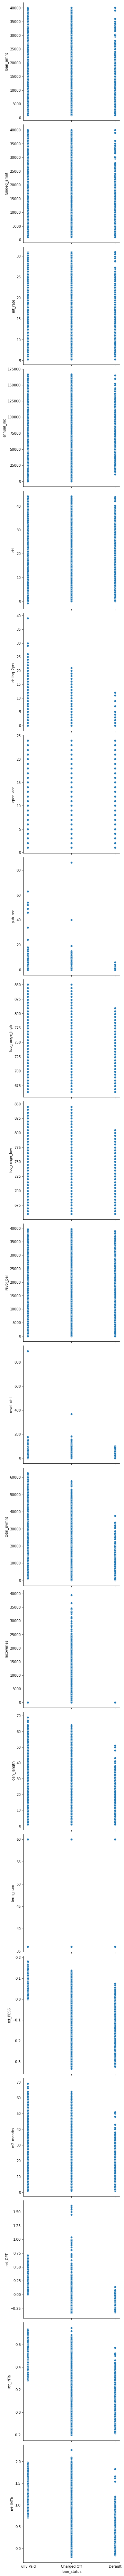

In [ ]:
# Visualize relation between loan status and features
... # sns pairplot or scatter plot. Refer to recitations

sns.pairplot(data = final_data,
            x_vars = "loan_status",height=5,aspect = 1)

### Data Exploration

In [ ]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data[["ret_OPT","grade"]].groupby("grade").mean()
# average return for M2-Optimistic for each loan grade

ret_by_grade_PESS = final_data[["ret_PESS","grade"]].groupby("grade").mean() 
# average return for M1-Pessimistic for each loan grade

ret_by_grade_INTa = final_data[["ret_INTa","grade"]].groupby("grade").mean()  
# average return for M3

ret_by_grade_INTb = final_data[["ret_INTb","grade"]].groupby("grade").mean() # average return for M3
int_rate_by_grade = final_data[["int_rate","grade"]].groupby("grade").mean() # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,17.679202,6.817245,7.230870,0.039306,0.011530,0.454761,1.338541
B,28.803775,14.189911,10.902355,0.049673,0.010578,0.447475,1.314430
C,27.837949,23.488257,14.216534,0.052472,0.000090,0.430563,1.282689
D,15.756340,31.583151,17.988589,0.056653,-0.007164,0.412598,1.242119
E,6.975418,39.936139,21.221552,0.058231,-0.013717,0.390503,1.185715
F,2.345548,46.154829,24.732362,0.062794,-0.016718,0.375765,1.148632
G,0.601768,50.290456,27.276953,0.062048,-0.029842,0.356006,1.121219


### Save a Pickle

In [ ]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features = [col for col in continuous_features if ((col != "total_pymnt") and (col != "recoveries"))]

In [ ]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )